In [75]:
import cv2
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
from projeto_helper import BeerClassification

PATH = 'C:\\Users\\marco\\Google Drive\\ComputerScience\\Visão Computacional\\images\\Skol'

def getHomography(query_kpts, train_kpts, matches):
    """Returns a homography matrix to transform the train image to match
    the query. 

    Adapted from: https://colab.research.google.com/drive/11Md7HWh2ZV6_g3iCYSUw76VNr4HzxcX5

    Parameters
    ----------
    query_kpts : ndarray of cv2.Keypoint
        Query image keypoints.

    train_kpts : ndarray of cv2.Keypoint
        Train image keypoints.

    matches : cv2.matches
        Matched descriptors of both images, use BeerClassification.matcher.

    Returns
    -------
    H : ndarray
        Homography matrix
    """
    # convert the keypoints to numpy arrays
    train_kpts = np.float32([kp.pt for kp in train_kpts])
    query_kpts = np.float32([kp.pt for kp in query_kpts])

    if len(matches) > 4:
        # construct the two sets of points
        train_pts = np.float32([train_kpts[m.queryIdx] for m in matches])
        query_pts = np.float32([query_kpts[m.trainIdx] for m in matches])

        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(train_pts, query_pts, cv2.RANSAC, 4)
        return H
    else:
        return None

def trim(img):
    m = 680
    n = 2711
    i = 872
    j = 2095
    img_crop = img[m : n + 1, i : j + 1, :]
    return img_crop

def SIFT(
    query_img,
    train_img,
    nfeatures=0, # best = 4000, 68500
    nOctaveLayers=3, # best = 6, 69002
    contrastThreshold=0.04, 
    edgeThreshold=10, # best = 4, 70734
    sigma=1.6): # best = 5, 70877

    s = cv2.SIFT_create(nfeatures, nOctaveLayers, contrastThreshold, edgeThreshold, sigma)
    query_kpts, query_desc = s.detectAndCompute(query_img, None)
    train_kpts, train_desc = s.detectAndCompute(train_img, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(train_desc, query_desc)
    matches = sorted(matches, key=lambda x:x.distance)

    H = getHomography(query_kpts, train_kpts, matches)
    width = query_img.shape[1]
    height = query_img.shape[0]
    train_img_t = cv2.warpPerspective(train_img, H, (width, height))

    query_img_s = cv2.GaussianBlur(query_img, (5, 5), cv2.BORDER_DEFAULT)
    train_img_s = cv2.GaussianBlur(train_img_t, (5, 5), cv2.BORDER_DEFAULT)
    img_diff = cv2.subtract(query_img_s, train_img_s)

    img_diff_trim = trim(img_diff)
    img_diff_gray = cv2.cvtColor(img_diff_trim, cv2.COLOR_RGB2GRAY)
    _, img_t = cv2.threshold(img_diff_gray, 50, 1, cv2.THRESH_BINARY)
    t = np.sum(img_t)

    fig, axs = plt.subplots(1, 2, figsize=(30, 10))
    img_match = cv2.drawMatches(train_img, train_kpts, query_img, query_kpts,
                                matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    axs[0].imshow(img_match)
    axs[0].set_title(f'kpts: {len(query_kpts)}')
    axs[1].imshow(img_t, 'gray')
    axs[1].set_title(f'pixels: {t}')
    plt.show()

    return t

In [76]:
bc = BeerClassification(PATH, ['0', '1', '2'])
query_img_0 = bc.getImage(bc.imgs[0])
query_img_45L = bc.getImage(bc.imgs[1])
query_img_45R = bc.getImage(bc.imgs[2])

mask_0 = plt.imread(join(PATH, 'mask0.jpg'))
mask_45L = plt.imread(join(PATH, 'mask45L.jpg'))
mask_45R = plt.imread(join(PATH, 'mask45R.jpg'))

query_img_0_m = cv2.bitwise_and(query_img_0, mask_0)
query_img_45L_m = cv2.bitwise_and(query_img_45L, mask_45L)
query_img_45R_m = cv2.bitwise_and(query_img_45R, mask_45R)

train_img_0 = bc.getImage(bc.imgs[75])
train_img_45L = bc.getImage(bc.imgs[76])
train_img_45R = bc.getImage(bc.imgs[77])

1.0


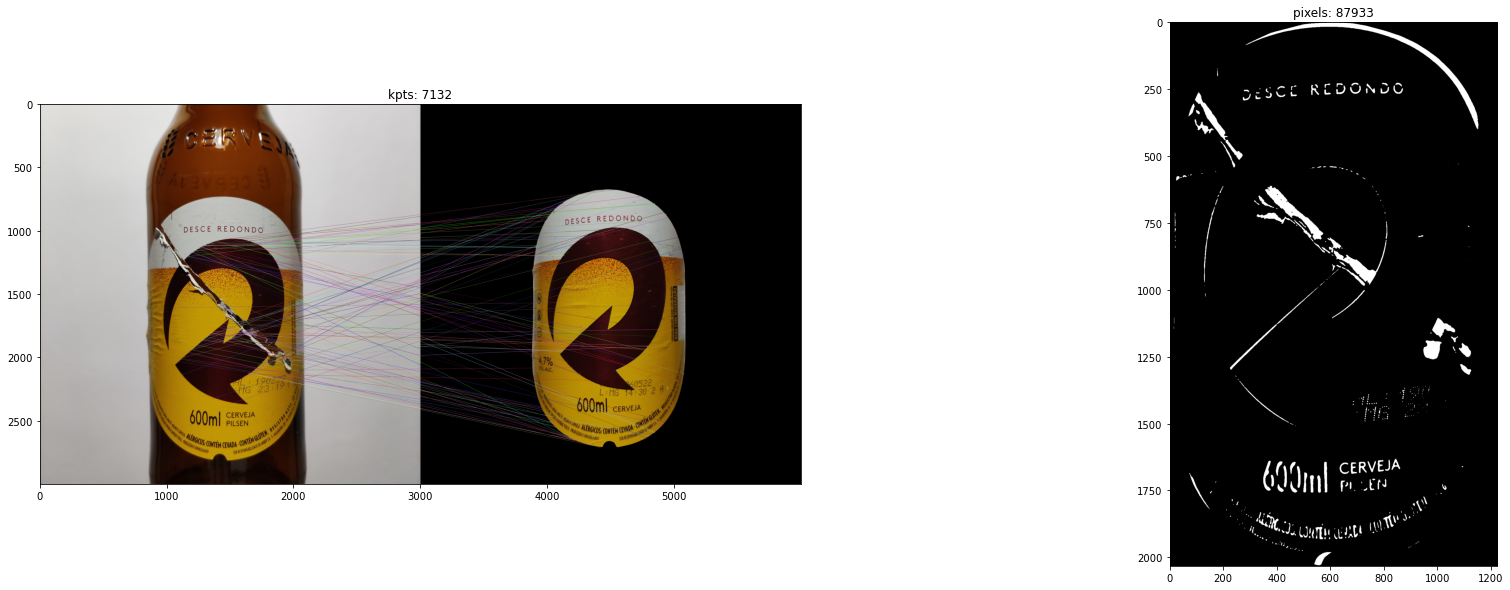

1.5


2.0


2.5


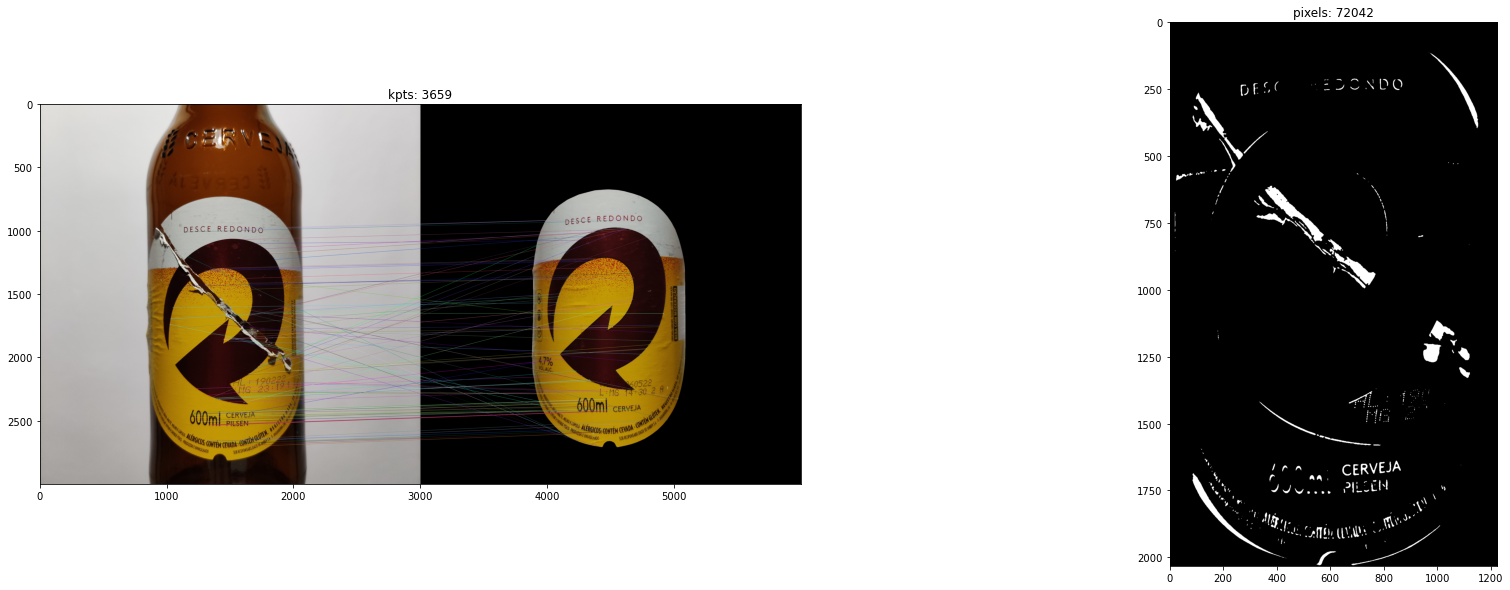

3.0


3.5


4.0


4.5


5.0


5.5


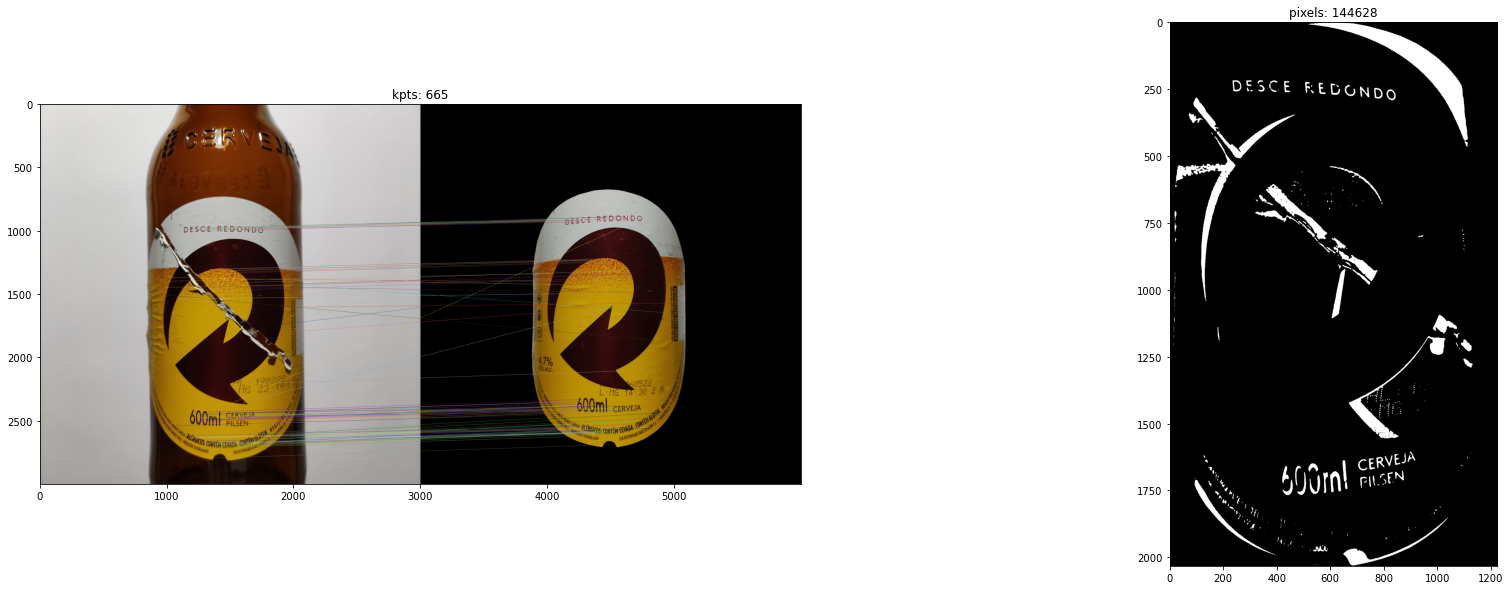

6.0


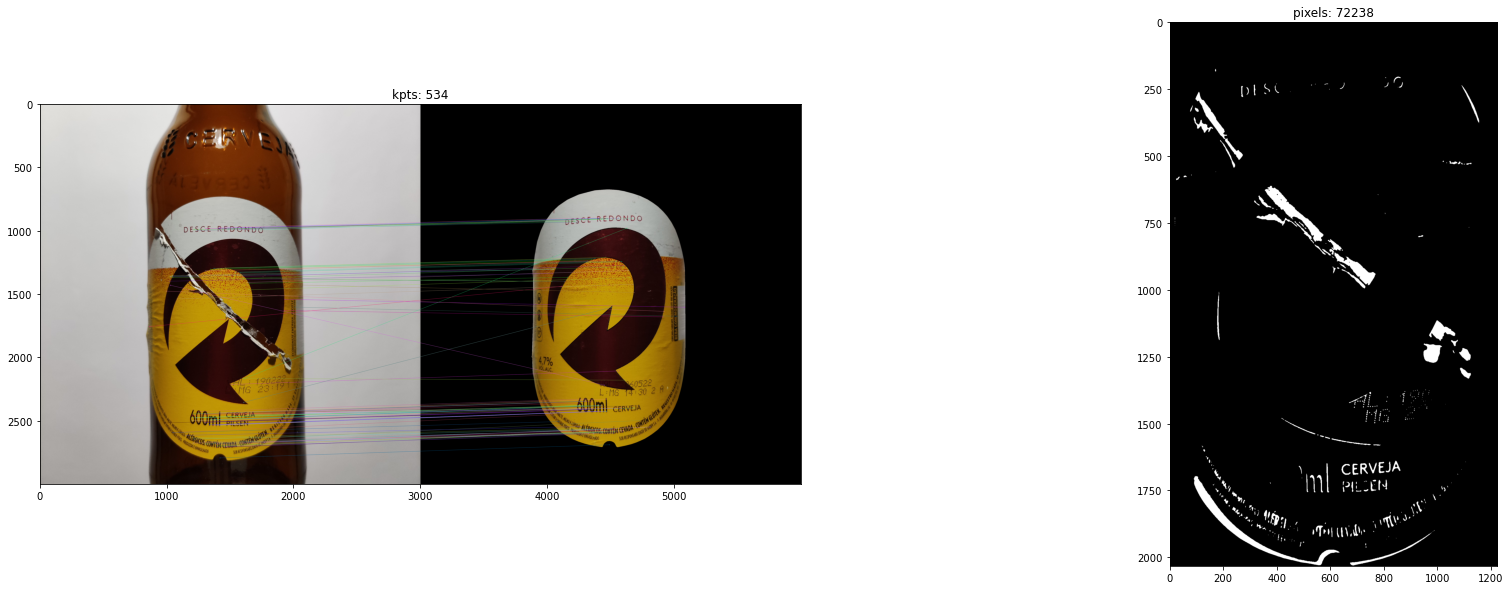

6.5


7.0


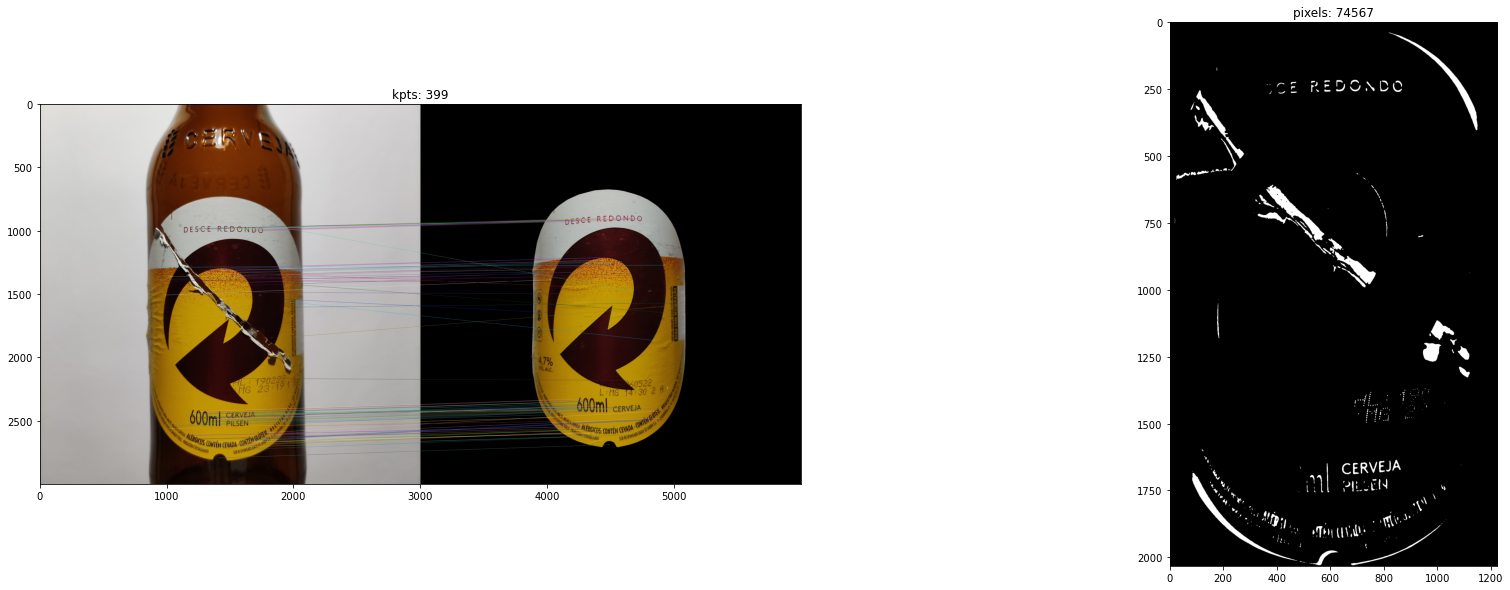

7.5


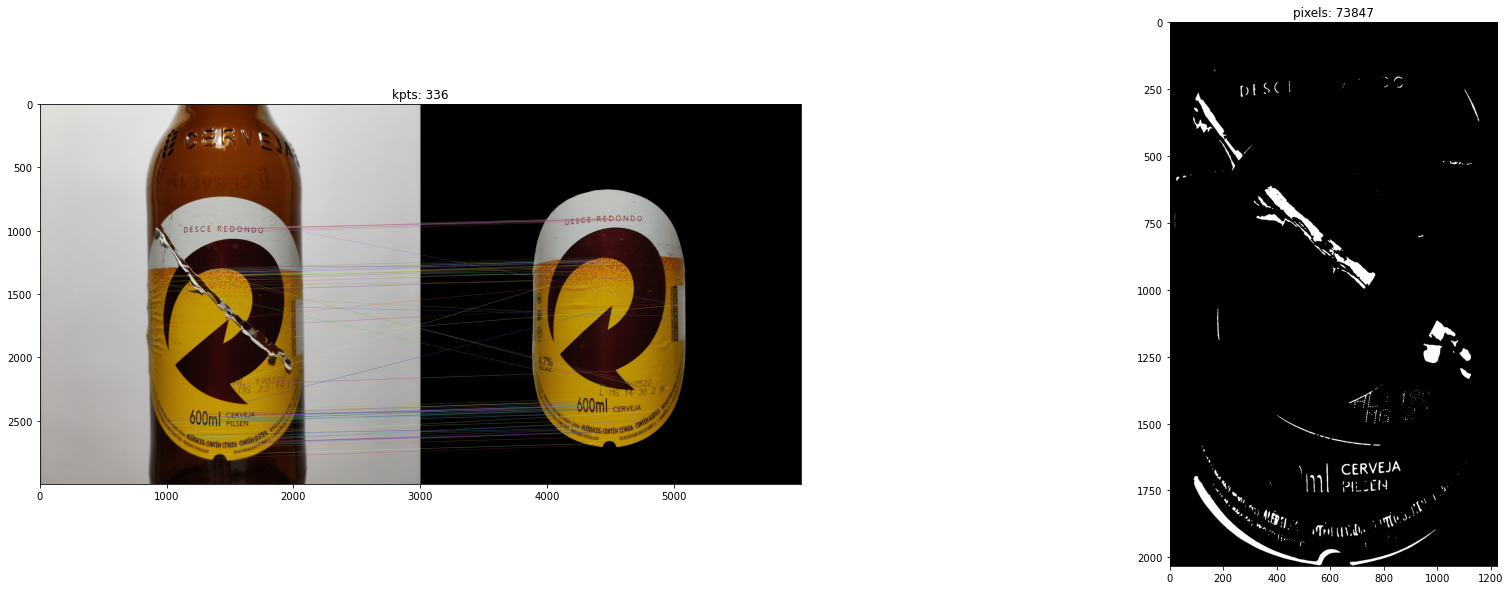

8.0


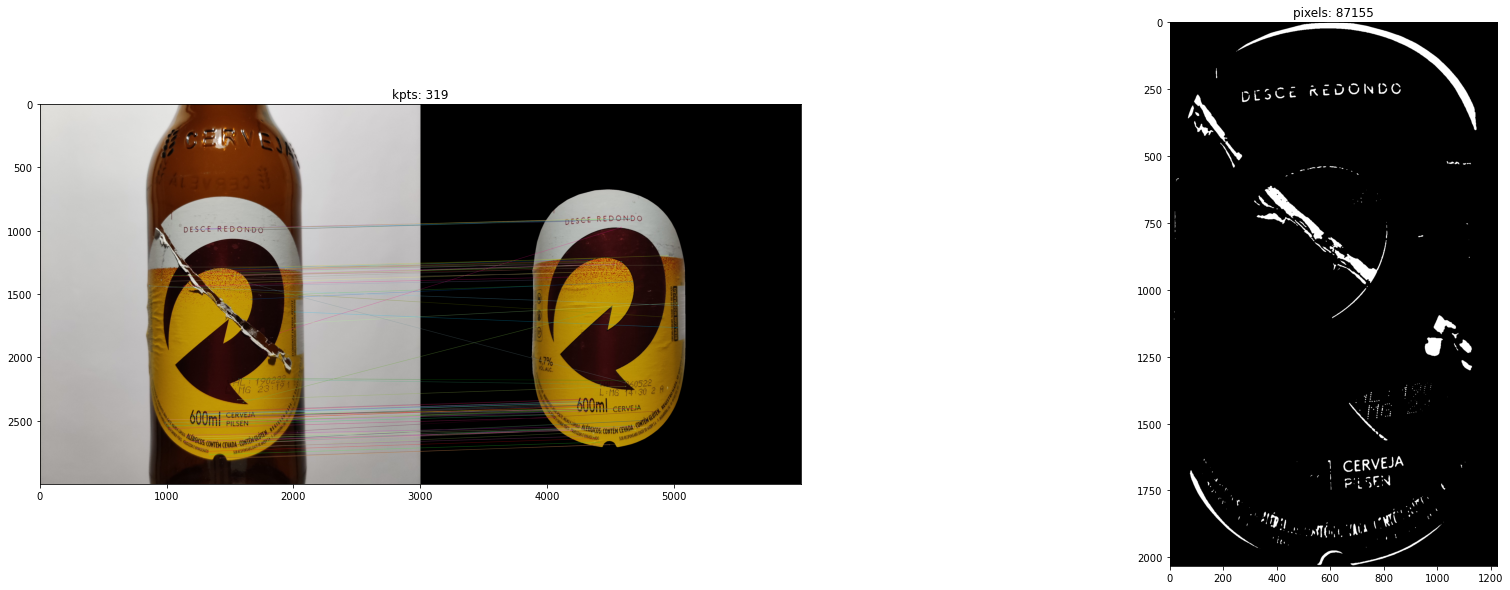

8.5


9.0


9.5


10.0


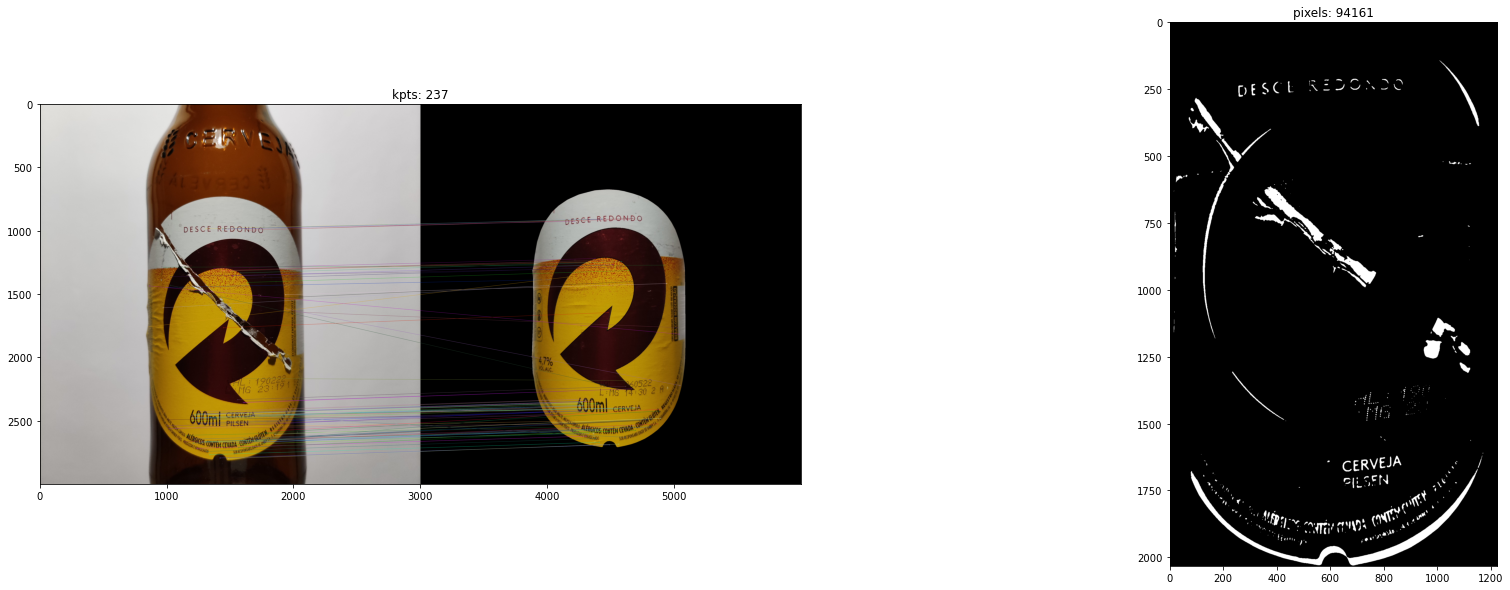

BEST === 70877 -> Parametro = [5.]


In [99]:
x = np.arange(1.0, 10.1, step=0.5)
results = []
for i in range(len(x)):
    print(x[i])
    results.append(SIFT(query_img_0_m, train_img_0, sigma=x[i]))
results = np.array(results)
print(f'BEST === {np.min(results)} -> Parametro = {x[np.where(results == np.min(results))[0]]}')

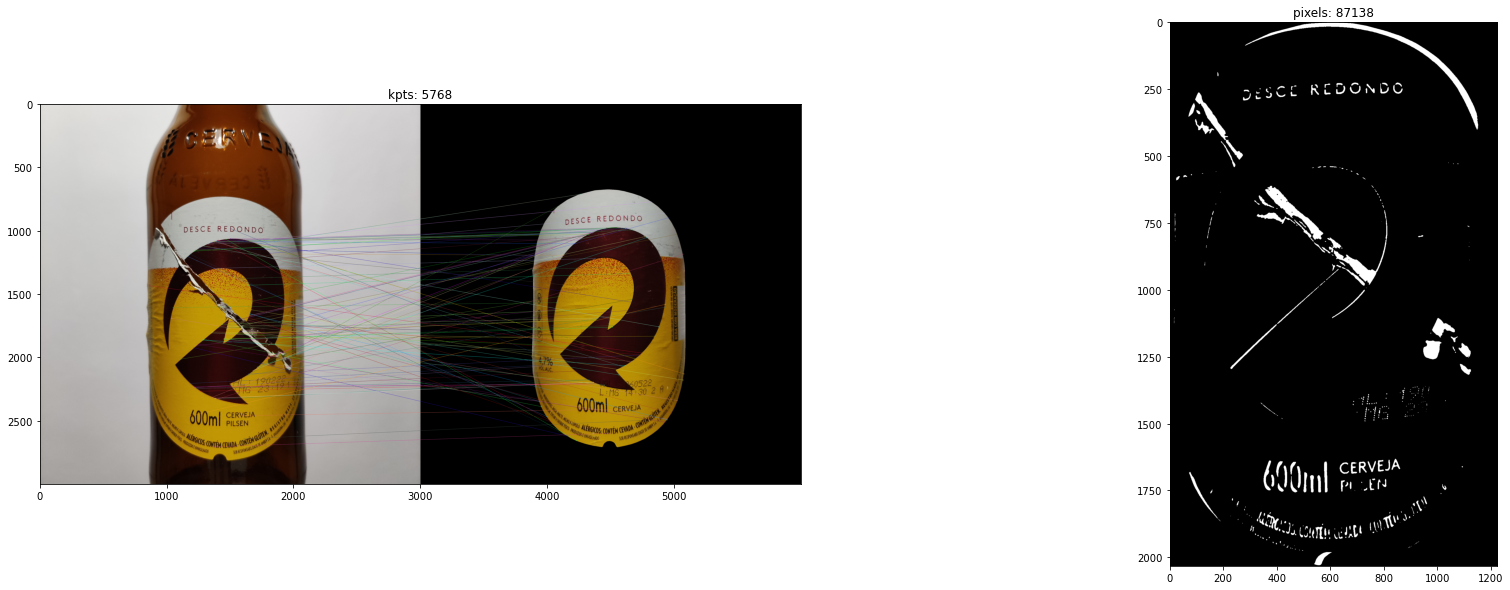

113943

In [112]:
SIFT(query_img_0_m, train_img_0)
SIFT(query_img_0_m, train_img_0, nfeatures=4000, nOctaveLayers=6, edgeThreshold=4, sigma=2.5)

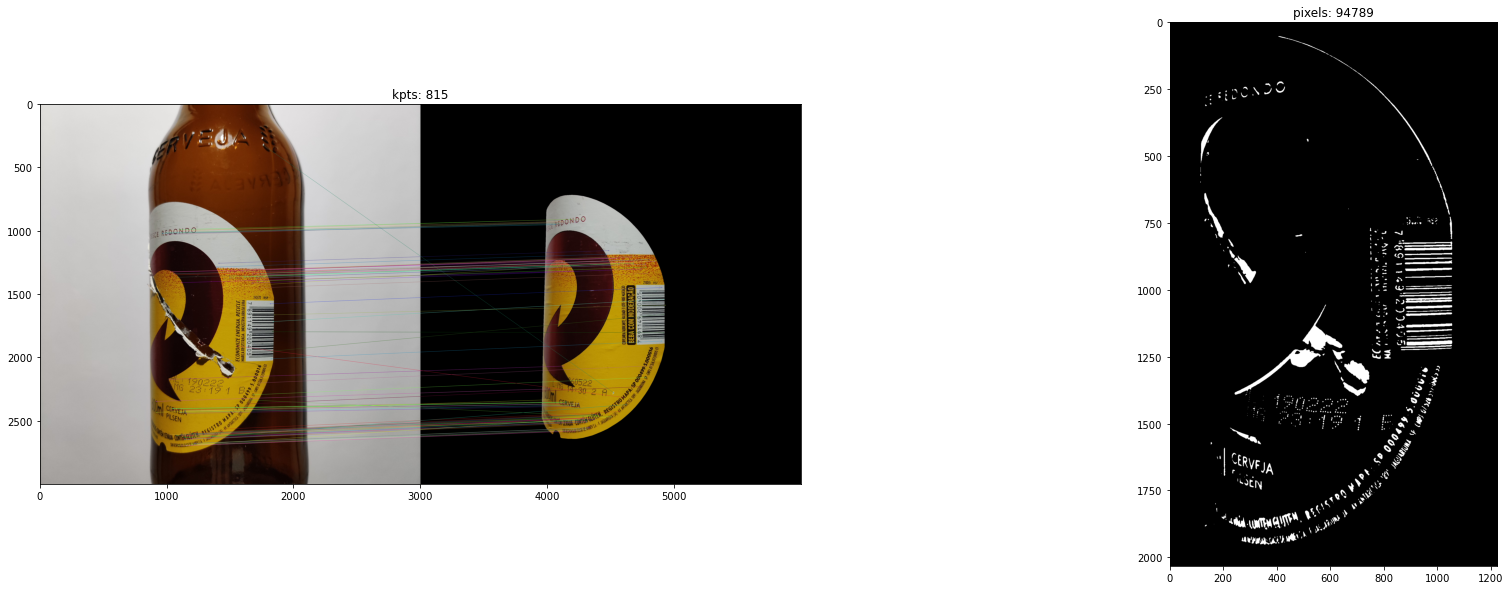

94789

In [113]:
SIFT(query_img_45L_m, train_img_45L)
SIFT(query_img_45L_m, train_img_45L, nfeatures=4000, nOctaveLayers=6, edgeThreshold=4, sigma=5.0)

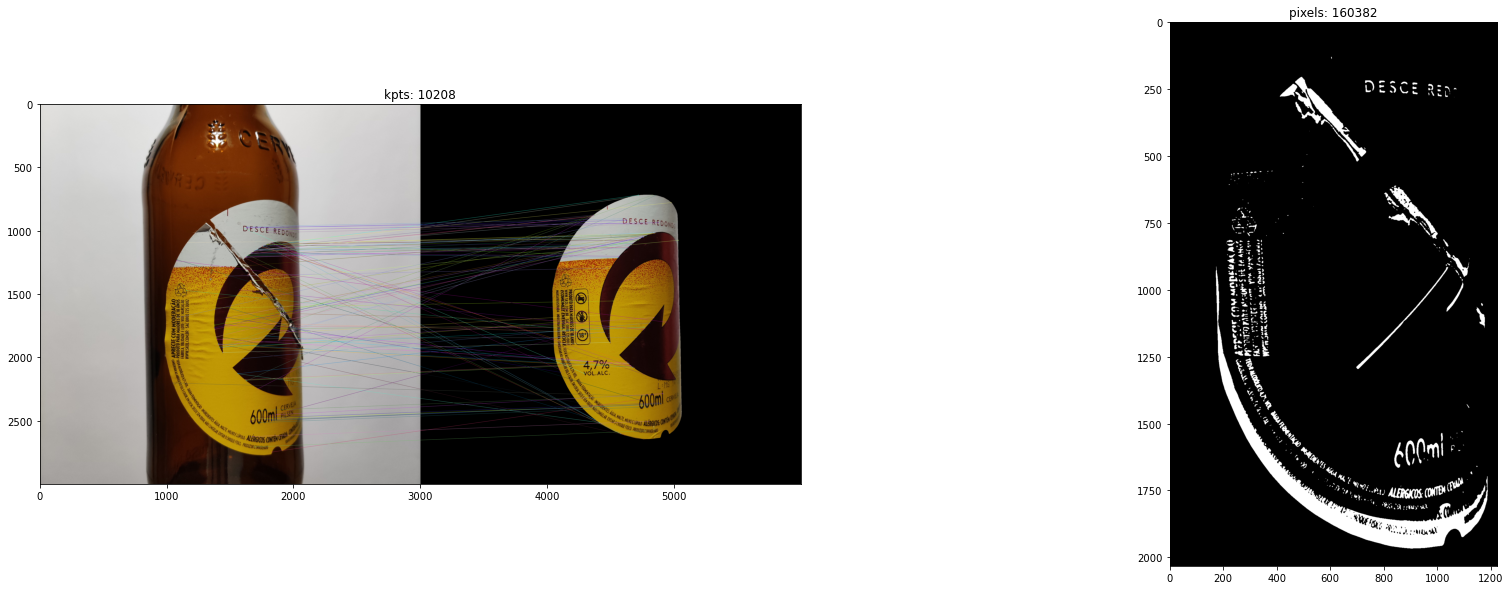

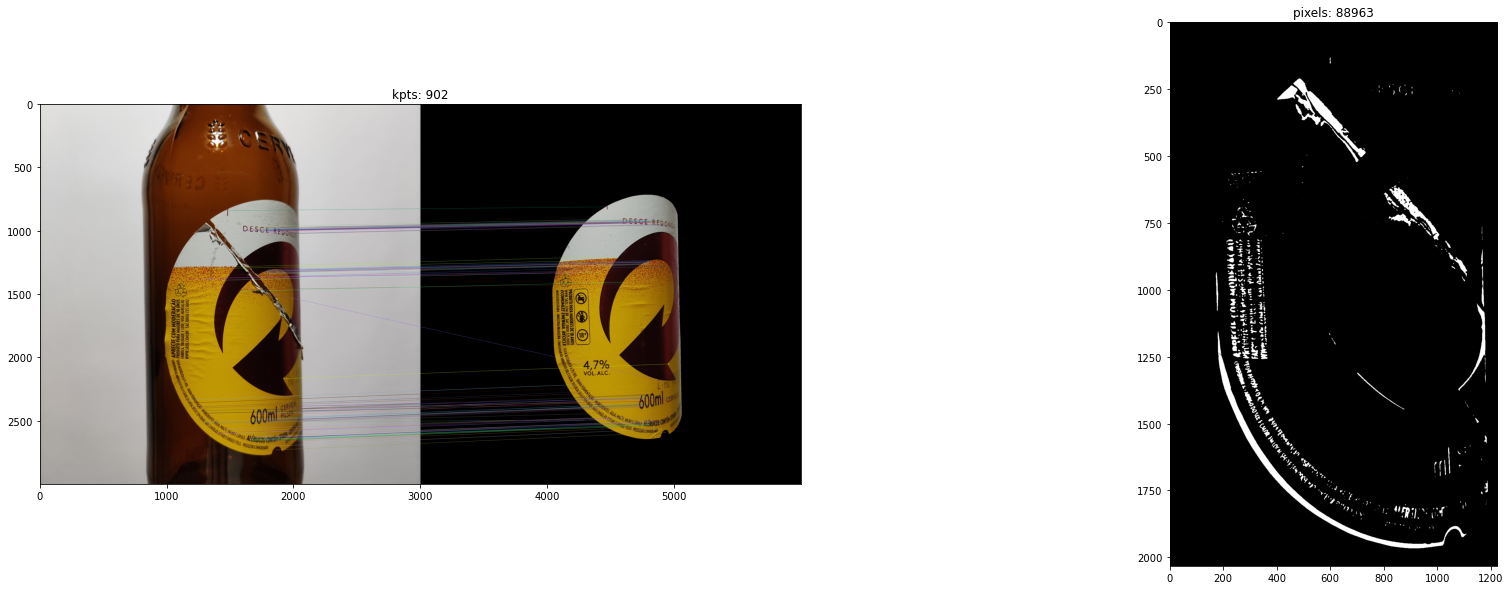

88963

In [114]:
SIFT(query_img_45R_m, train_img_45R)
SIFT(query_img_45R_m, train_img_45R, nfeatures=4000, nOctaveLayers=6, edgeThreshold=4, sigma=5.0)